<h1>Experimentos de Topologia</h1>
<p>Experimentos realizados com o objetivo de encontrar uma topologia para uma rede neural convolucional que seja capaz de aprender o procedimento de <b>esteganografia</b>, ou seja, escoder e revelar um arquivo binário em uma imagem digital.</p>

<h3>Importação de bibliotecas</h3>

In [1]:
import os

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import math
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from skimage.metrics import mean_squared_error
from skimage.io import imshow, imread, imsave
from tqdm.notebook import tqdm, trange
import time
import string

from IPython import display

<h3>Definição da semente do gerador de números aleatórios para permitir a reprodução dos experimentos realizados</h3>

In [3]:
os.environ['PYTHONHASHSEED']=str(456)
np.random.seed(456)
random.seed(456)

<h3>Declaração de funções para armazenar/recuperar um arquivo binário no ruído de uma imagem</h3>

In [4]:
# função responsável por definir quais pontos da imagem conterá o ruído da mensagem secreta
def generateMatStegano():
    mat = np.zeros((64, 64))
    
    for i in range(64):
        randIdxs = random.sample(range(0, 64), 21)
        
        for j in range(64):
            if j in randIdxs:
                mat[i][j] = 1
            
    return mat

matStegano = generateMatStegano()

In [5]:
# Função responsável por adicionar na imagem um ruído representando a mensagem secreta
def stegano(img, msg):
    retImg = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    
    z = 0
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                retImg[i][j][k] = img[i][j][k]

                if matStegano[i][j] == 1:
                    if msg[z] == 0:
                        retImg[i][j][k] = 0
                    else:
                        retImg[i][j][k] = 255
            
            if matStegano[i][j] == 1:
                z += 1
    
    return retImg

In [6]:
# Função responsável por extrair a mensagem secreta do ruído da imagem
def steganoInv(img):
    msg = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if matStegano[i][j] == 1:
              media = 0

              for k in range(img.shape[2]):
                media += img[i][j][k]

              media /= img.shape[2]

              if media >= 127:
                  msg.append(1)
              else:
                  msg.append(0)
    
    msg = np.array(msg)
    
    return msg

<h3>Leitura e pré-processamento do dataset</h3>

In [7]:
images = []

for file in os.listdir('dataset'):
    try:
        img = imread('dataset/' + file)

        if img.shape == (64, 64, 3):
          images.append(img)
    except:
        continue

images = np.array(images)

In [8]:
images.shape

(4881, 64, 64, 3)

In [9]:
n = images.shape[0]

In [10]:
train_images, test_images = images[:int(n*0.75)], images[int(n*0.75):]

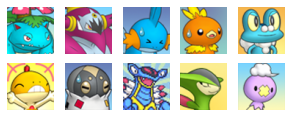

In [11]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_example.png')
plt.show()

In [12]:
train_images_original = np.array(train_images, copy=True)
test_images_original = np.array(test_images, copy=True)

In [13]:
train_images.shape

(3660, 64, 64, 3)

<h3>Geração das mensagens secretas, aplicação do código de haming para aumentar a redundancia e armazenamento da mensagem secreta nos arquivos do dataset</h3>

In [14]:
def neededRedundantBits(m):
  for r in range(m + 1):
    if 2 ** r >= m + r + 1:
      return r
  return 0

In [15]:
tot = 1344

secretLength = 0

for i in range(tot + 1):
  if i + neededRedundantBits(i) == tot:
    secretLength = i
    break

print(tot, secretLength)

1344 1333


In [16]:
nHammer = tot - secretLength

In [17]:
# Função responsável por codificar a mensagem utilizando codificação de hammer
def preparaHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0
  k = 0

  for i in range(1, len(mensagem) + nHammerBits + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[k])
      k += 1

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  return retorno

In [18]:
# Função responsável por decodificar a mensagem utilizando codificação de hammer
def corrigeHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0

  for i in range(1, len(mensagem) + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[i - 1])

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  vet = ""

  for i in range(nHammerBits):
    vet += str(mensagem[(1<<i) - 1] ^ retorno[(1<<i) - 1])

  r = int(vet[::-1], 2)

  return r

In [19]:
preparaHammerArray([1, 1, 1, 1], 3)

[1, 1, 1, 1, 1, 1, 1]

In [20]:
corrigeHammerArray([1, 1, 1, 1, 1, 1, 1], 3)

0

In [21]:
# Função responsavél po gerar uma sequencia de bits que representa uma string aleatória, simulando a sequencia de bits de arquivos .txt
def generateStrBin(secretSize):
  message = []
  
  nChar = secretSize // 8

  randomStr = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(nChar))

  for i in randomStr:
    k = ord(i)
    for j in range(8):
      message.append(k & 1)
      k >>= 1

  while(len(message) < secretSize):
    message.append(0)

  return message

In [22]:
# armazena as mensagens secretas no dataset de treino
train_images2 = train_images
shape = train_images2.shape
train_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

train_messages = [];

for i in trange(train_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    train_messages.append(message)
    
    train_images[i] = stegano(train_images2[i], message).astype('int')
    
train_messages = np.array(train_messages)

  0%|          | 0/3660 [00:00<?, ?it/s]

In [23]:
# armazena as mensagens secretas no dataset de teste
test_images2 = test_images
shape = test_images2.shape
test_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

test_messages = [];

for i in trange(test_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    test_messages.append(message)
    
    test_images[i] = stegano(test_images2[i], message)
    
test_messages = np.array(test_messages)

  0%|          | 0/1221 [00:00<?, ?it/s]

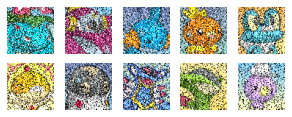

In [24]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_noisy.png')
plt.show()

In [25]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images_original = train_images_original.astype('float32') / 255.
test_images_original = test_images_original.astype('float32') / 255.

print (train_images.shape)
print (test_images.shape)
print (train_images_original.shape)
print (test_images_original.shape)

(3660, 64, 64, 3)
(1221, 64, 64, 3)
(3660, 64, 64, 3)
(1221, 64, 64, 3)


<h3>Definição das topologias a serem testadas para o encoder e decoder</h3>

In [26]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [27]:
encoder = []

for j in range(1, 6):
  inputLayer = layers.Input(shape=(64, 64, 3))

  x = inputLayer

  for k in range(j):
    x = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid' + str(k) + '_3x3')(x)
  
  outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_C')(x)

  model = Model(inputs=inputLayer, outputs=outputLayer, name = 'Encoder')

  encoder.append(model)

In [28]:
encoder[0].summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_hid0_3x3 (Conv2D)      (None, 64, 64, 50)        1400      
                                                                 
 output_C (Conv2D)           (None, 64, 64, 3)         1353      
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [29]:
decoder = []

for j in range(1, 6):
  inputLayer = layers.Input(shape=(64, 64, 3))

  x = inputLayer

  for k in range(j):
    x = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev' + str(k) + '_3x3')(x)

  outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_S')(x)

  model = Model(inputs=inputLayer, outputs=outputLayer, name = 'Decoder')

  decoder.append(model)

In [30]:
decoder[0].summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_rev0_3x3 (Conv2D)      (None, 64, 64, 50)        1400      
                                                                 
 output_S (Conv2D)           (None, 64, 64, 3)         1353      
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [31]:
i = 0
for model in encoder:
  tf.keras.utils.plot_model(model, to_file='model_encoder_' + str(i) + '.png', show_shapes=True)
  i += 1

In [32]:
i = 0
for model in decoder:
  tf.keras.utils.plot_model(model, to_file='model_decoder_' + str(i) + '.png', show_shapes=True)
  i += 1

In [33]:
len(encoder)

5

In [34]:
len(decoder)

5

<h3>Treinamento da rede neural convolucional encoder</h3>

In [35]:
encoder_optimizer = []

for i in encoder:
  encoder_optimizer.append(tf.keras.optimizers.Adam())

In [36]:
decoder_optimizer = []

for i in decoder:
  decoder_optimizer.append(tf.keras.optimizers.Adam())

In [37]:
history = []

for i in range(len(encoder)):
  encoder[i].compile(optimizer='adam', loss=losses.MeanSquaredError())
  hist = encoder[i].fit(train_images, train_images_original,
                  epochs=20,
                  shuffle=False,
                  validation_data=(test_images, test_images_original))
  history.append(hist)

Epoch 1/20
115/115 [==============================] - 13s 12ms/step - loss: 0.0421 - val_loss: 0.0255
Epoch 2/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0197 - val_loss: 0.0172
Epoch 3/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0170 - val_loss: 0.0163
Epoch 4/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 5/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0157 - val_loss: 0.0151
Epoch 6/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 7/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 8/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 9/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0132 - val_loss: 0.0128
Epoch 10/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0125 - val_loss: 0.01

In [38]:
print(history[0].history.keys())

dict_keys(['loss', 'val_loss'])


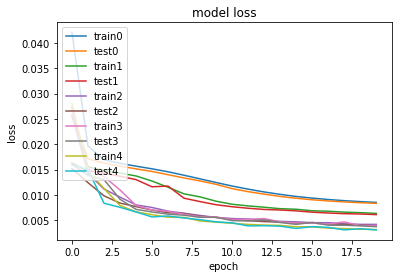

In [39]:
legend = []

i = 0

for hist in history:
  plt.plot(hist.history['loss'])
  legend.append('train' + str(i))

  plt.plot(hist.history['val_loss'])
  legend.append('test' + str(i))

  i += 1

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('first_training.png')
plt.show()

<h3>Treinamento adversarial das redes neurais convolucionais encoder e decoder</h3>

In [40]:
EPOCHS = 20
BATCH_SIZE = 32

In [41]:
mseFun = losses.MeanSquaredError()

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, originalImages, enc, dec, enc_opt, dec_opt):
    with tf.GradientTape() as encoder_tape, tf.GradientTape() as decoder_tape:
      encoded_images = enc(images, training=True)
      decoded_images = dec(encoded_images, training=True)

      encoded_loss = mseFun(originalImages, encoded_images)
      decoded_loss = mseFun(images, decoded_images)
      total_loss = encoded_loss + decoded_loss

    gradients_of_encoder = encoder_tape.gradient(total_loss, enc.trainable_variables)
    gradients_of_decoder = decoder_tape.gradient(decoded_loss, dec.trainable_variables)

    enc_opt.apply_gradients(zip(gradients_of_encoder, enc.trainable_variables))
    dec_opt.apply_gradients(zip(gradients_of_decoder, dec.trainable_variables))

    return total_loss

In [43]:
def train(dataset, datasetTest, epochs, enc, dec, enc_opt, dec_opt):
  lossVet = []
  lossTestVet = []

  for epoch in trange(epochs):
    start = time.time()

    lenDataset = dataset.shape[0]
    nBatches = math.floor(lenDataset / BATCH_SIZE)

    total_loss = 0

    for i in trange(nBatches):
      total_loss += train_step(dataset[i:i + BATCH_SIZE], train_images_original[i:i + BATCH_SIZE], enc, dec, enc_opt, dec_opt)
    
    total_loss /= nBatches

    lossVet.append(total_loss)

    encoded_images_test = enc(datasetTest, training=False)
    decoded_images_test = dec(encoded_images_test, training=False)

    encoded_loss_test = mseFun(test_images_original, encoded_images_test)
    decoded_loss_test = mseFun(datasetTest, decoded_images_test)
    total_loss_test = encoded_loss_test + decoded_loss_test

    lossTestVet.append(total_loss_test)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return lossVet, lossTestVet

In [44]:
train_images_original.shape

(3660, 64, 64, 3)

In [45]:
history = []
historyTest = []

for i in range(len(encoder)):
  hist, histTest = train(train_images, test_images, EPOCHS, encoder[i], decoder[i], encoder_optimizer[i], decoder_optimizer[i])
  history.append(hist)
  historyTest.append(histTest)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 4.2875306606292725 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 3.734600782394409 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 3.71087384223938 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 3.7492456436157227 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 3.7519726753234863 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 3.74029541015625 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 3.773183584213257 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 3.7101662158966064 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 3.712559223175049 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 3.7476744651794434 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 3.7482824325561523 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 3.7212414741516113 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 3.7287657260894775 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 3.737868547439575 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 3.7337493896484375 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 3.719316244125366 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 3.7590596675872803 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 3.754840135574341 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 3.767875909805298 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 3.74890398979187 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 5.3342015743255615 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 5.117077827453613 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 5.1097571849823 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 5.192728757858276 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 5.55301308631897 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 5.153340578079224 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 5.162437915802002 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 5.153696775436401 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 5.15812087059021 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 5.122344732284546 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 5.099114656448364 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 5.150315523147583 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 5.150923252105713 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 5.123044490814209 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 5.132424831390381 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 5.119098901748657 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 5.145349502563477 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 5.142240047454834 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 5.097196578979492 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 5.114812135696411 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 6.938006401062012 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 6.9051194190979 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 6.915591239929199 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 6.93729305267334 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 6.936675310134888 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 6.90179705619812 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 6.879655122756958 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 6.877721548080444 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 6.901168584823608 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 6.913306951522827 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 6.88718581199646 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 6.925918817520142 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 6.965665340423584 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 6.916816234588623 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 7.320389747619629 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 6.949437856674194 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 6.998172760009766 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 6.916651725769043 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 7.000036716461182 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 7.2180585861206055 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 8.67727518081665 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 8.518488883972168 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 8.55912446975708 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 8.697920322418213 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 8.656281232833862 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 8.587845087051392 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 8.594385862350464 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 8.597761392593384 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 8.605037689208984 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 8.606168270111084 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 8.549980401992798 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 8.54241943359375 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 8.600522518157959 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 8.626797676086426 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 8.576814889907837 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 8.590007305145264 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 8.630385160446167 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 8.540068864822388 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 8.556267499923706 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 8.519396781921387 sec


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 1 is 10.345327138900757 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 2 is 10.291624307632446 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 3 is 10.256428718566895 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 4 is 10.333519697189331 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 5 is 10.435615062713623 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 6 is 10.240046501159668 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 7 is 10.309506893157959 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 8 is 10.200597524642944 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 9 is 10.211511135101318 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 10 is 10.19550633430481 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 11 is 10.22231388092041 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 12 is 10.150898456573486 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 13 is 10.20575761795044 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 14 is 10.239612579345703 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 15 is 10.235957860946655 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 16 is 10.185757875442505 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 17 is 10.198529481887817 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 18 is 10.285765886306763 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 19 is 10.353402376174927 sec


  0%|          | 0/114 [00:00<?, ?it/s]

Time for epoch 20 is 10.339484214782715 sec


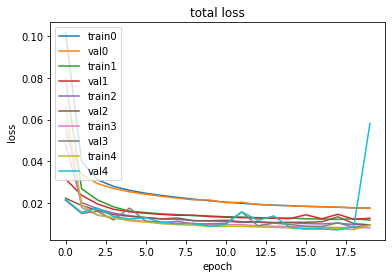

In [46]:
legend = []

for i in range(len(history)):
  plt.plot(history[i])
  legend.append('train' + str(i))

  plt.plot(historyTest[i])
  legend.append('val' + str(i))

plt.title('total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('second_training.png')
plt.show()

<h3>Avaliação dos resultados obtidos</h3>

In [47]:
encoded_imgs = []
decoded_imgs = []

for i in range(len(encoder)):
  encoded_imgs.append(encoder[i](test_images).numpy())
  decoded_imgs.append(decoder[i](encoded_imgs[i]).numpy())

  encoded_imgs[i] = encoded_imgs[i] * 255
  encoded_imgs[i] = encoded_imgs[i].astype('int')

  decoded_imgs[i] = decoded_imgs[i] * 255
  decoded_imgs[i] = decoded_imgs[i].astype('int')

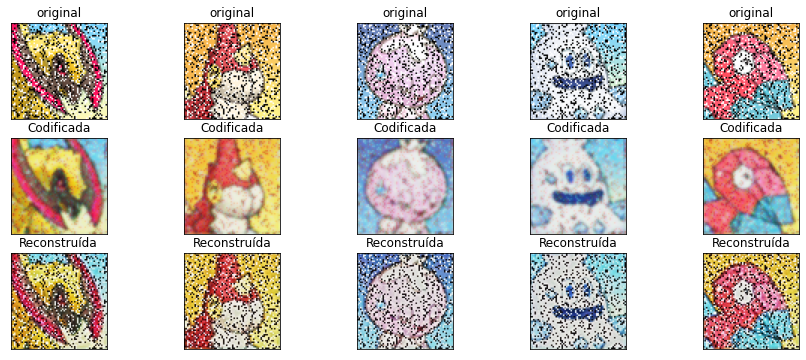

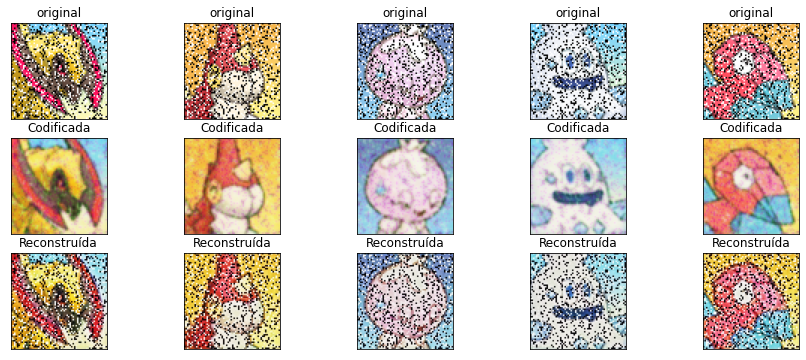

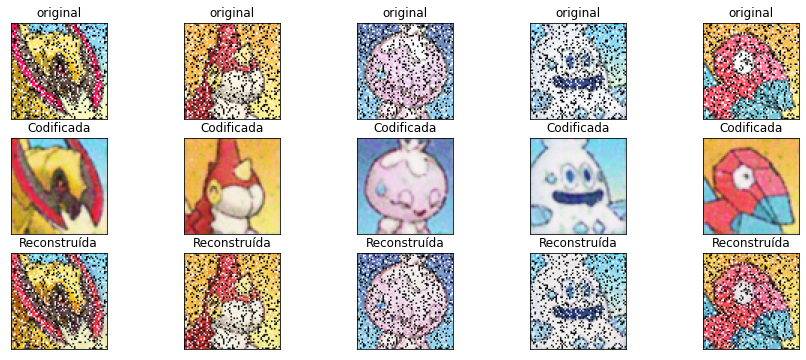

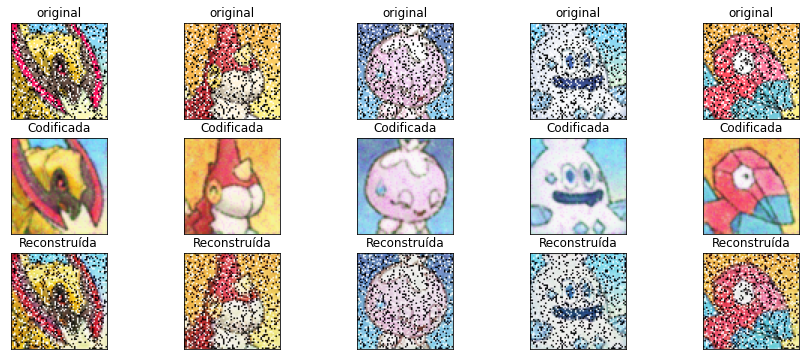

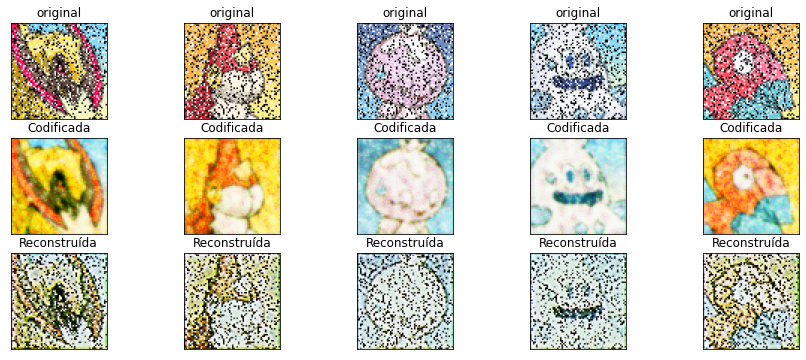

In [48]:
for k in range(len(encoder)):
  n = 5
  plt.figure(figsize=(15, 6))
  for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[k][i])
    plt.title("Codificada")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[k][i])
    plt.title("Reconstruída")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
  plt.savefig('img_results_' + str(k) + '.png')
  plt.show()

<h3>Medidas de semelhanças entre a imagem original e a imagem com a mensagem escodida</h3>

In [49]:
mseMean = []

for enc_set in encoded_imgs:
  enc_set = enc_set / 255
  mseSum = 0
  for i in range(test_images_original.shape[0]):
    mseSum += mean_squared_error(test_images_original[i], enc_set[i])
    
  mseMean.append(mseSum / test_images_original.shape[0])

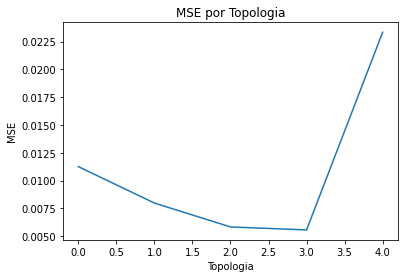

In [50]:
plt.plot(mseMean)
plt.title('MSE por Topologia')
plt.ylabel('MSE')
plt.xlabel('Topologia')
plt.savefig('mse_por_topologia.png')
plt.show()

<h3>Média de erro de bit na recuperação das mensagens secretas por topologia</h3>

In [51]:
def erroBits(x, y):
  qtd = 0

  for i in range(x.shape[0]):
    if x[i] != y[i]:
      qtd += 1

  return qtd

In [53]:
listaMediaErro = []

for k in range(len(encoder)):
  mediaErro = 0

  j = 0

  for i in decoded_imgs[k]:
      a = np.array(i, copy=True)
      msgA = steganoInv(a)
      idxBitErro = corrigeHammerArray(msgA, nHammer)
      if idxBitErro > 0 and idxBitErro < len(msgA):
        msgA[idxBitErro - 1] = ~msgA[idxBitErro - 1] & 1
      
      erroValor = erroBits(test_messages[j], msgA)

      mediaErro += erroValor

      j += 1

  mediaErro /= decoded_imgs[k].shape[0]

  listaMediaErro.append(mediaErro)

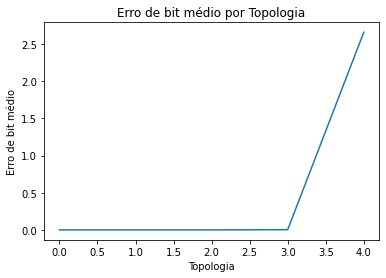

In [54]:
plt.plot(listaMediaErro)
plt.title('Erro de bit médio por Topologia')
plt.ylabel('Erro de bit médio')
plt.xlabel('Topologia')
plt.savefig('erro_de_bit_medio_por_topologia.png')
plt.show()

In [55]:
test_images_original.min()

0.0